In [1]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import nibabel as nib
import nilearn as nil
import pandas as pd
import numpy as np

from EDA import *
from dataloaders import *
from utils import *
import config

def plot_3d(data):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(data[:, :, data.shape[2] // 2], cmap="gray")
    axes[0].set_title("Axial Slice")
    axes[0].axis("off")
    axes[1].imshow(data[:, data.shape[1] // 2, :], cmap="gray")
    axes[1].set_title("Coronal Slice")
    axes[1].axis("off")
    axes[2].imshow(data[data.shape[0] // 2, :, :], cmap="gray")
    axes[2].set_title("Sagittal Slice")
    axes[2].axis("off")
    plt.show()

In [2]:
dataset_dir = config.dataset_dir
subject_id = 1
sic_candidate = 26

In [3]:
bold, _ = data_import(dataset    = config.dataset_dir,
                      subject_id = config.subject_id,
                      subfolder  = 'pre_bold\\pre_bold_preprocessed.ica',
                      data_name  = ['filtered_func_data'])

sica, save_dir = data_import(dataset    = config.dataset_dir,
                             subject_id = config.subject_id,
                             subfolder  = 'pre_bold\\pre_bold_preprocessed.ica\\filtered_func_data.ica',
                             data_name  = ['mask','melodic_IC'])


selected data:
D:\Academic\Datasets\Epilepsy_rsfMRI_Fallahi\Sub001\pre_bold\pre_bold_preprocessed.ica\filtered_func_data.nii.gz  >> Shape: (91, 109, 91, 320)

selected data:
D:\Academic\Datasets\Epilepsy_rsfMRI_Fallahi\Sub001\pre_bold\pre_bold_preprocessed.ica\filtered_func_data.ica\mask.nii.gz  >> Shape: (91, 109, 91)
D:\Academic\Datasets\Epilepsy_rsfMRI_Fallahi\Sub001\pre_bold\pre_bold_preprocessed.ica\filtered_func_data.ica\melodic_IC.nii.gz  >> Shape: (91, 109, 91, 30)


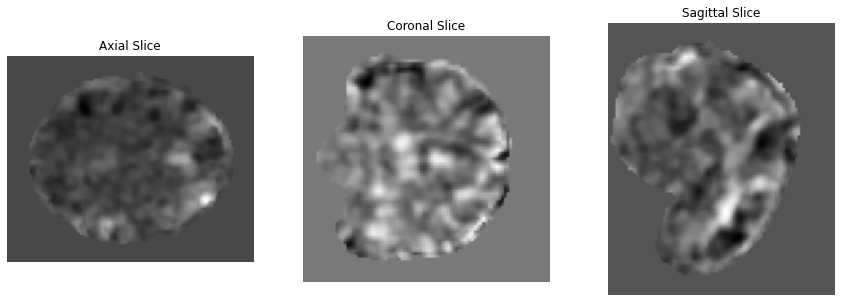

In [4]:
selected_ic = ic_extract(sica['melodic_IC'],config.sic_candidate)
plot_3d(selected_ic)

In [5]:
def calculate_lateralization_index_from_IC(IC_matrix):
# Ensure the input is of the correct shape
    if IC_matrix.shape != (91, 109, 91):
        raise ValueError("IC_matrix must be of shape (91, 109, 91)")

    # Define the ACPC plane (mid-sagittal plane)
    mid_plane_index = 45  # This is the zero-based index for the mid-sagittal plane

    left_voxels = []
    right_voxels = []
    
    # Extract mirroring voxels from both sides of the brain
    for x in range(mid_plane_index):
        mirrored_x = IC_matrix.shape[0] - 1 - x  # Find the mirroring voxel
        left_voxels.append(IC_matrix[x, :, :])
        right_voxels.append(IC_matrix[mirrored_x, :, :])
    
    # Flatten the voxel arrays
    left_voxels = np.array(left_voxels).flatten()
    right_voxels = np.array(right_voxels).flatten()
    
    # Calculate Pearson's correlation coefficient (symmetricity)
    correlation, _ = pearsonr(left_voxels, right_voxels)
    
    # Calculate mean and standard deviation of symmetricity
    symmetricities = [correlation]  # In a more complex scenario, you might have multiple ICs
    mean_symmetricity = np.mean(symmetricities)
    std_symmetricity = np.std(symmetricities)
    
    # Determine cut-off for symmetricity
    cutoff = mean_symmetricity - std_symmetricity
    
    # Filter out components with symmetricity greater than the cut-off
    if correlation <= cutoff:
        # Calculate Lateralization Index (LI)
        LI = (np.sum(left_voxels) - np.sum(right_voxels)) / (np.sum(left_voxels) + np.sum(right_voxels))
        return {"Lateralization Index": LI, "Symmetricity": correlation}
    else:
        return {"Lateralization Index": None, "Symmetricity": correlation}

LI_result = calculate_lateralization_index_from_IC(selected_ic)
print("Lateralization Index:", LI_result["Lateralization Index"])
print("Symmetricity:", LI_result["Symmetricity"])

Lateralization Index: -0.5461504444760564
Symmetricity: 0.3746853916110681



criterion indices: [(65, 35, 64)]
XYZ coordinates:   [(26, 36, 65)]
MNI coordinates:   [(-40.0, -56.0, 56.0)]


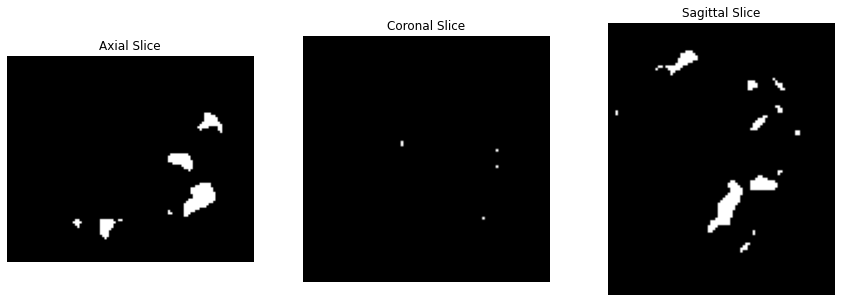

In [6]:
indices, selected_ic_cluster = ic_browse(selected_ic = selected_ic,
                                         criterion   = selected_ic >= 3.1,
                                         affine      = sica['melodic_IC'].affine,
                                         show        = False)

max_value, _ = ic_browse(selected_ic = selected_ic,
                         criterion   = selected_ic >= selected_ic.max(),
                         affine      = sica['melodic_IC'].affine,
                         show        = True)

plot_3d(selected_ic_cluster)

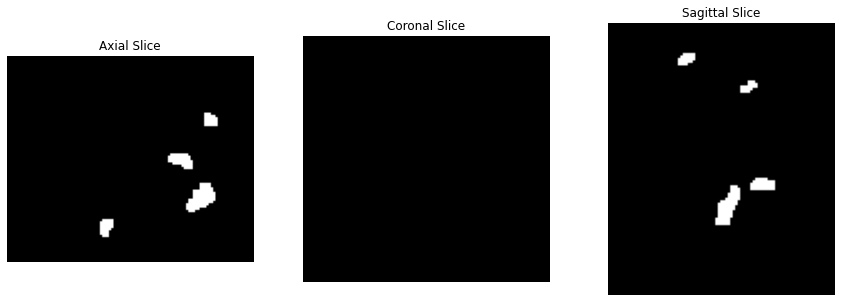

In [7]:
selected_ic_cluster = morphological_operation(selected_ic_cluster)
plot_3d(selected_ic_cluster)

In [8]:
BLI_result = binary_lateralization(selected_ic_cluster)
BLI_result

{'Left Binary Lateralization': 0.708,
 'Right Binary Lateralization': 0.125,
 'Lateralization Strength': 0.699,
 'Side': 'Left'}

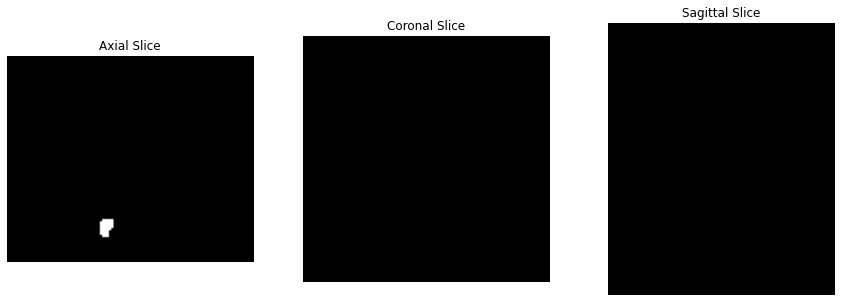

In [9]:
selected_ic_mask = mask_cc_around_coordinate(selected_ic_cluster, max_value["Max_index"][0])
plot_3d(selected_ic_mask)

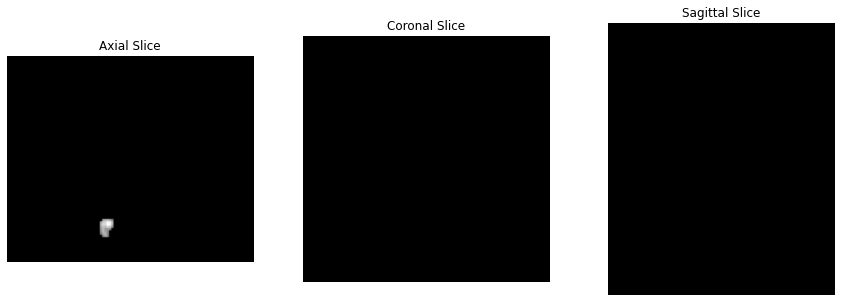

In [10]:
selected_ic_masked = selected_ic_mask * selected_ic
plot_3d(selected_ic_masked)

In [11]:
# selected_ic_fMRI = np.expand_dims(selected_ic_mask, axis=-1) * bold['filtered_func_data'].get_fdata()

In [12]:
fmri_data = bold['filtered_func_data'].get_fdata()
ic_mask = selected_ic_mask
ic_fmri = fmri_data[ic_mask > 0]
# ic_timeseries = fmri_data[ic_mask > 0].T

In [13]:
# def cluster_connectivity(fmri_data, mask):
#     masked_voxels = fmri_data[mask > 0]
#     time_series = masked_voxels.T
#     connectivity_matrix = np.corrcoef(time_series.T)
#     return connectivity_matrix

# connectivity_matrix = cluster_connectivity(bold['filtered_func_data'].get_fdata(), selected_ic_mask)
# plt.imshow(connectivity_matrix)

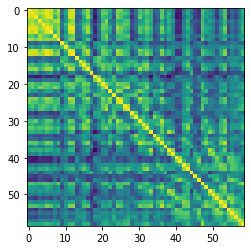

In [14]:
def cluster_connectivity_ds(fmri_data, mask, downsample_factor=2):
    if isinstance(downsample_factor, int):
        downsample_factor = (downsample_factor, downsample_factor, downsample_factor)
    downsampled_fmri = zoom(fmri_data, zoom=(1/downsample_factor[0], 1/downsample_factor[1], 1/downsample_factor[2], 1), order=1)
    downsampled_mask = zoom(mask, zoom=(1/downsample_factor[0], 1/downsample_factor[1], 1/downsample_factor[2]), order=0)
    masked_voxels = downsampled_fmri[downsampled_mask > 0]
    time_series = masked_voxels.T
    connectivity_matrix = np.corrcoef(time_series.T)    
    return connectivity_matrix

connectivity_matrix = cluster_connectivity_ds(bold['filtered_func_data'].get_fdata(), selected_ic_mask, downsample_factor=3)
plt.imshow(connectivity_matrix)

In [15]:
def voxel_network_strength(fmri_data, mask, voxel_index):
    if mask[voxel_index] == 0:
        raise ValueError("The specified voxel_index is not within the masked region.")
    time_series = fmri_data[mask > 0].T
    voxel_time_series = fmri_data[voxel_index].flatten()
    num_voxels = time_series.shape[1]
    network = np.zeros(num_voxels)
    for i in range(num_voxels):
        network[i] = np.corrcoef(time_series[:, i], voxel_time_series)[0, 1]
    network = np.sort(network)[::-1]
    network_strength = round(sum(network)/num_voxels,3)
    return network_strength

central_network_strength = voxel_network_strength(bold['filtered_func_data'].get_fdata(), selected_ic_mask, max_value["Max_index"][0])
print("Central Network Strength:",central_network_strength)

Central Network Strength: 0.474


# Topological Measures

In [16]:
import numpy as np
import networkx as nx

from bct import clustering_coef_bu

def calculate_clustering_coefficients(connectivity_matrix, random_matrices):
    # Local Clustering Coefficient
    G = nx.from_numpy_array(connectivity_matrix)
    local_clustering = clustering_coef_bu(connectivity_matrix)
    absolute_clustering_coefficient = np.mean(local_clustering)
    
    # Normalized Clustering Coefficient
    random_clustering_coeffs = []
    for random_matrix in random_matrices:
        random_clustering = clustering_coef_bu(random_matrix)
        random_clustering_coeffs.append(np.mean(random_clustering))
    Crandom = np.mean(random_clustering_coeffs)
    normalized_clustering_coefficient = absolute_clustering_coefficient / Crandom
    
    return absolute_clustering_coefficient, normalized_clustering_coefficient

from bct import distance_bin

def calculate_characteristic_path_length(connectivity_matrix, random_matrices):
    D = distance_bin(connectivity_matrix)
    L = np.mean(D[np.isfinite(D)])
    
    random_path_lengths = []
    for random_matrix in random_matrices:
        D_random = distance_bin(random_matrix)
        L_random = np.mean(D_random[np.isfinite(D_random)])
        random_path_lengths.append(L_random)
    Lrandom = np.mean(random_path_lengths)
    normalized_path_length = L / Lrandom
    
    return L, normalized_path_length

def calculate_small_world_index(gamma, lambda_):
    sigma = gamma / lambda_
    return sigma

from bct import efficiency_bin

def calculate_efficiency_measures(connectivity_matrix):
    local_efficiency = np.mean(efficiency_bin(connectivity_matrix, local=True))
    global_efficiency = efficiency_bin(connectivity_matrix, local=False)
    
    return local_efficiency, global_efficiency

def calculate_connectivity_strength(connectivity_matrix):
    strength = np.mean(connectivity_matrix[np.triu_indices_from(connectivity_matrix, k=1)])
    return strength

def calculate_connectivity_diversity(connectivity_matrix):
    N = connectivity_matrix.shape[0]
    mean_pairwise_correlations = np.mean(connectivity_matrix, axis=1)
    connectivity_diversity = np.var(connectivity_matrix - mean_pairwise_correlations[:, None], axis=1)
    average_connectivity_diversity = np.mean(connectivity_diversity)
    
    return average_connectivity_diversity

def calculate_betweenness_centrality(connectivity_matrix, hippocampal_nodes):
    G = nx.from_numpy_array(connectivity_matrix)
    betweenness = nx.betweenness_centrality(G, normalized=True)
    
    bc_left = betweenness[hippocampal_nodes['LH']]
    bc_right = betweenness[hippocampal_nodes['RH']]
    
    return bc_left, bc_right

def compute_topological_measures(connectivity_matrix, random_matrices, hippocampal_nodes):
    # 1. Clustering Coefficients
    C, gamma = calculate_clustering_coefficients(connectivity_matrix, random_matrices)
    
    # 2. Characteristic Path Length
    L, lambda_ = calculate_characteristic_path_length(connectivity_matrix, random_matrices)
    
    # 3. Small-World Index
    sigma = calculate_small_world_index(gamma, lambda_)
    
    # 4. Efficiency Measures
    local_efficiency, global_efficiency = calculate_efficiency_measures(connectivity_matrix)
    
    # 5. Connectivity Strength
    CS = calculate_connectivity_strength(connectivity_matrix)
    
    # 6. Connectivity Diversity
    CD = calculate_connectivity_diversity(connectivity_matrix)
    
    # 7. Betweenness Centrality
    bc_left, bc_right = calculate_betweenness_centrality(connectivity_matrix, hippocampal_nodes)
    
    return {
        'Clustering Coefficient': round(C,3),
        # 'Normalized Clustering Coefficient (gamma)': round(gamma,3),
        'Characteristic Path Length': round(L,3),
        # 'Normalized Characteristic Path Length (lambda)': round(lambda_,3),
        # 'Small-World Index (sigma)': round(sigma,3),
        'Local Efficiency': round(local_efficiency,3),
        # 'Global Efficiency': round(global_efficiency,3),
        'Connectivity Strength': round(CS,3),
        'Connectivity Diversity': round(CD,3),
        # 'Betweenness Centrality (Left Hippocampus)': round(bc_left,3),
        # 'Betweenness Centrality (Right Hippocampus)': round(bc_right,3),
    }


In [17]:
def generate_random_matrices(connectivity_matrix, num_random_matrices=500):
    random_matrices = []
    for _ in range(num_random_matrices):
        random_matrix = np.random.permutation(connectivity_matrix.flatten()).reshape(connectivity_matrix.shape)
        random_matrices.append(random_matrix)
    return random_matrices

In [18]:
random_matrices = generate_random_matrices(connectivity_matrix, num_random_matrices=500)
hippocampal_nodes = {'LH': 0, 'RH': 1}  # Indices for left and right hippocampus
TM_result = compute_topological_measures(connectivity_matrix, random_matrices, hippocampal_nodes)
for measure, value in TM_result.items():
    print(f"{measure}: {value}")

Clustering Coefficient: 0.352
Characteristic Path Length: 0.983
Local Efficiency: 1.0
Connectivity Strength: 0.335
Connectivity Diversity: 0.059


In [21]:
max_value_fmri = fmri_data[max_value["Max_index"][0]]
max_area_fmri = mean_fmri_in_neighborhood(fmri_data, max_value["Max_index"][0], 3)
R_outside_inside = outside_inside_ratio(selected_ic, sica['mask'])
max_power_freq = max_power_frequency(max_area_fmri, tr=3.0)

In [19]:
sIC_Features = {
    'Subject ID': subject_id,
    'sIC Number': sic_candidate,
    'sIC Center': max_value['MNI_coords'],
    'Lateralization Index': LI_result['Lateralization Index'],
    'Lateralization Strength': BLI_result['Lateralization Strength'],
    'Lateralization Side': BLI_result['Side'],
    'Centeral Network': central_network_strength,
    'Clustering Coefficient': TM_result['Clustering Coefficient'],
    'Characteristic Path Length': TM_result['Characteristic Path Length'],
    'Local Efficiency': TM_result['Local Efficiency'],
    'Connectivity Strength': TM_result['Connectivity Strength'],
    'Connectivity Diversity': TM_result['Connectivity Diversity'],  
}

df = pd.DataFrame(sIC_Features, index=[0])
results_path = 'results/sIC_Features.csv'

if os.path.isfile(results_path):
    df.to_csv(results_path, mode='a', index=False, header=False)
else:
    df.to_csv(results_path, index=False, header=True)